In [22]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from src.utils import ROOT_DIR
from src.dataset import CustomDataset
from src.models import Flamingo0S
from src.utils import load_json
from open_flamingo import create_model_and_transforms
import torch
import os
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image as to_pil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Load the dataset
dataset = CustomDataset(
    csv_file=os.path.join(ROOT_DIR, "data", "MMHS150K", "MMHS150K_text_in_image.csv"),
    img_dir=os.path.join(ROOT_DIR, "data", "MMHS150K", "img_resized/"),
    split="test"
)

In [5]:
LANG_MODEL_PATH=os.path.join(ROOT_DIR, 'data','pretrained_models','RedPajama-INCITE-Base-3B-v1')
CACHE_MODEL= os.path.join(ROOT_DIR, 'data','pretrained_models')
FLAMINGO_MODEL_PATH=os.path.join(ROOT_DIR, 'data','pretrained_models','OpenFlamingo-3B-vitl-mpt1b', 'checkpoint.pt' )

model, image_processor, tokenizer = create_model_and_transforms(
    clip_vision_encoder_path="ViT-L-14",
    clip_vision_encoder_pretrained="openai",
    lang_encoder_path=LANG_MODEL_PATH,
    tokenizer_path=LANG_MODEL_PATH,
    cross_attn_every_n_layers=2,
    cache_dir=os.path.join(ROOT_DIR, 'data','pretrained_models')
)
model.load_state_dict(torch.load(FLAMINGO_MODEL_PATH), strict=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Flamingo model initialized with 1089480736 trainable parameters


_IncompatibleKeys(missing_keys=['vision_encoder.class_embedding', 'vision_encoder.positional_embedding', 'vision_encoder.proj', 'vision_encoder.conv1.weight', 'vision_encoder.ln_pre.weight', 'vision_encoder.ln_pre.bias', 'vision_encoder.transformer.resblocks.0.ln_1.weight', 'vision_encoder.transformer.resblocks.0.ln_1.bias', 'vision_encoder.transformer.resblocks.0.attn.in_proj_weight', 'vision_encoder.transformer.resblocks.0.attn.in_proj_bias', 'vision_encoder.transformer.resblocks.0.attn.out_proj.weight', 'vision_encoder.transformer.resblocks.0.attn.out_proj.bias', 'vision_encoder.transformer.resblocks.0.ln_2.weight', 'vision_encoder.transformer.resblocks.0.ln_2.bias', 'vision_encoder.transformer.resblocks.0.mlp.c_fc.weight', 'vision_encoder.transformer.resblocks.0.mlp.c_fc.bias', 'vision_encoder.transformer.resblocks.0.mlp.c_proj.weight', 'vision_encoder.transformer.resblocks.0.mlp.c_proj.bias', 'vision_encoder.transformer.resblocks.1.ln_1.weight', 'vision_encoder.transformer.resbloc

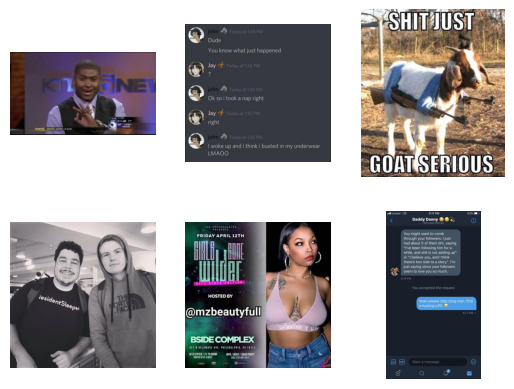

In [51]:
f=plt.figure()
for i in range(0, 6):
    f.add_subplot(2, 3, i + 1)
    plt.imshow(to_pil(dataset[i]['image']))
    plt.axis('off')

In [3]:
model = Flamingo0S(
    config_path=os.path.join(ROOT_DIR, "data", "config", "config_Flamingo0S.json")
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Flamingo model initialized with 1089480736 trainable parameters


# Exemple from the src implementation

In [19]:
from PIL import Image
import requests
import torch
from src.dataset import CustomDataset

"""
Step 1: Load images
"""
demo_image_one = dataset[0]['image']
query_image = dataset[1]['image']
vision_x = [image_processor(demo_image_one).unsqueeze(0),image_processor(query_image).unsqueeze(0)]
vision_x = torch.cat(vision_x, dim=0).unsqueeze(1).unsqueeze(0)


tokenizer.padding_side = "left" # For generation padding tokens should be on the left
lang_x = tokenizer(
    ["<image>This is a hateful meme. We consider it as hateful due to the fact that it targets a specific community<|endofchunk|><image>This meme is"],
    return_tensors="pt",
)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7F0E3EF0BAD0>
(1, 1, 3, 224, 224)
(1, 3, 224, 224)
(1, 1, 1, 3, 224, 224)


In [5]:
generated_text = model.generate(
    vision_x=vision_x,
    lang_x=lang_x["input_ids"],
    attention_mask=lang_x["attention_mask"],
    max_new_tokens=20,
    num_beams=3,
)
print("Generated text: ", tokenizer.decode(generated_text[0]))

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image>Describe this image.<|endofchunk|><image>An image of a person or thing that is used as a symbol or representative of a particular thing or idea.



In [4]:
model.initialize_prompt(dataset)

{'1023944988365709312': '<image>Classification: Hateful/nThis meme represents hateful speech due to the fact that it targets a specific community and oversimplifies the situation.', '1023962536549523461': '<image>Classification: Hatefuff/nThis meme represents hateful speech due to the fact that it promotes unsocial behavior.', '1024035166304387073': '<image>Classification: Hateful/nThis meme represents hateful speech due to the fact that it refers to conspiracy theory.', '1024027652733194241': "<image>Classification: Not Hateful/nThis meme doesn't represent hateful speech. It only display sarcasm."}
1023944988365709312 <image>Classification: Hateful/nThis meme represents hateful speech due to the fact that it targets a specific community and oversimplifies the situation.
1023962536549523461 <image>Classification: Hatefuff/nThis meme represents hateful speech due to the fact that it promotes unsocial behavior.
1024035166304387073 <image>Classification: Hateful/nThis meme represents hate

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


"<image>Classification: Hateful/nThis meme represents hateful speech due to the fact that it targets a specific community and oversimplifies the situation.<|endofchunk|><image>Classification: Hatefuff/nThis meme represents hateful speech due to the fact that it promotes unsocial behavior.<|endofchunk|><image>Classification: Hateful/nThis meme represents hateful speech due to the fact that it refers to conspiracy theory.<|endofchunk|><image>Classification: Not Hateful/nThis meme doesn't represent hateful speech. It only display sarcasm. bClassification: Not Hateful/nThis meme doesn't represent hateful speech."